---
|Hands-on Activity 4.1|Introduction to Pytorch|
|-|-|
|Course Code & Section|CPE313-CPE32S3|
|Course Title|Advanced Machine Learning and Deep Learning|
|Name|De Guzman, Aero Kent|
|Date Performed|12/02/26|
|Date Submitted|16/02/26|
|Instructor|Engr. Neil Barton James Matira|
---

*The procedures are at a separate file*

---
# **SUPPLEMENTARY**
---
1. Create a dataset with appropriate samples and classes.
2. Demonstrate machine learning with PyTorch.
---

In [1]:
# Libraries
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

## **Create a dataset with appropriate samples and classes**

**Dataset:** https://www.kaggle.com/datasets/die9origephit/nike-adidas-and-converse-imaged?select=test

**About the data:** \
Train Data= 711 \
Test Data= 114 \
Resolution= 240x240 RGB

* Adidas
* Converse
* Nike

In [43]:
train_path = "/content/drive/MyDrive/Colab Notebooks/DATASET(S)/HOA4-1/train"
test_path = "/content/drive/MyDrive/Colab Notebooks/DATASET(S)/HOA4-1/test"

transform = transforms.Compose([
  transforms.Grayscale(num_output_channels=1),
  transforms.ToTensor(),
])

training_data = datasets.ImageFolder(
    root = train_path,
    transform = transform
)

test_data = datasets.ImageFolder(
    root = test_path,
    transform = transform
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [44]:
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0]
label = train_labels[0]
print(training_data.classes)
print(f"Label index: {label}")
print(f"Class name: {training_data.classes[label]}")

['adidas', 'converse', 'nike']
Label index: 0
Class name: adidas


In [45]:
print(img.size())

torch.Size([1, 240, 240])


In [46]:
flatten = nn.Flatten()
print(flatten(img).size())

torch.Size([1, 57600])


Feature batch shape: torch.Size([64, 1, 240, 240])
Labels batch shape: torch.Size([64])


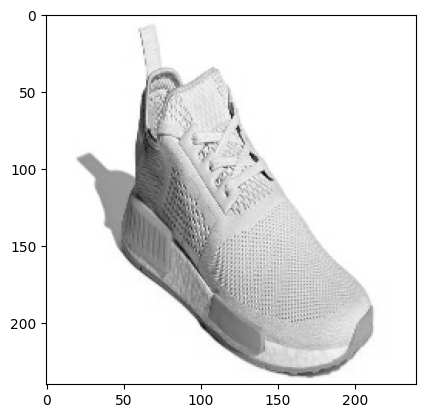

Label: 0


In [47]:
img = img.permute(1, 2, 0)
label = train_labels[0].item()
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## **Build the Neural Network**

In [55]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [75]:
class C_NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.CNN = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size = 3, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Conv2d(16, 32, kernel_size = 3, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2),

      nn.Flatten(),
      nn.Linear(128 * 15 * 15, 256),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(256, 3)
    )

  def forward(self, x):
    return self.CNN(x)

model = C_NeuralNetwork().to(device)

In [76]:
print(model)

C_NeuralNetwork(
  (CNN): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=28800, out_features=256, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=256, out_features=3, bias=True)
  )
)


In [77]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    pred = model(X)
    loss = loss_fn(pred, y)
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * batch_size + len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [81]:
learning_rate = 1e-4
batch_size = 64
epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.039034  [   64/  711]
Test Error: 
 Accuracy: 46.5%, Avg loss: 1.033261 

Epoch 2
-------------------------------
loss: 1.033854  [   64/  711]
Test Error: 
 Accuracy: 52.6%, Avg loss: 1.025279 

Epoch 3
-------------------------------
loss: 1.022486  [   64/  711]
Test Error: 
 Accuracy: 53.5%, Avg loss: 1.028109 

Epoch 4
-------------------------------
loss: 1.012894  [   64/  711]
Test Error: 
 Accuracy: 52.6%, Avg loss: 1.007491 

Epoch 5
-------------------------------
loss: 0.991217  [   64/  711]
Test Error: 
 Accuracy: 52.6%, Avg loss: 1.006349 

Epoch 6
-------------------------------
loss: 1.022427  [   64/  711]
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.001405 

Epoch 7
-------------------------------
loss: 0.981599  [   64/  711]
Test Error: 
 Accuracy: 52.6%, Avg loss: 0.989273 

Epoch 8
-------------------------------
loss: 0.948884  [   64/  711]
Test Error: 
 Accuracy: 51.8%, Avg loss: 1.000127 

Epoch 9
----------------

---
# **Conclusion**
---
To conclude the following activity it was not about building a model using pytorch. The procedures spanned 6 topics from differing files which is the supplementary is in this another separated file as well.


First off is when it comes to the data tutorial as the first topic, this discusses concepts when it comes to loading visualizing data from pytorch either the data within the library of it or creating the own data with it. Data within can be selected using the datasets library containing various datasets already gathered or one can import some. Then it will be now prepared for training using dataloader. In short the key functions needed here is the datasets and ImageFolder being the new one that I selected since the data I gathered is already compiled already as well as the dataloader which prepares the data for training.


After the datas are processed the model will now be built and compared to other methods such as a line by line method like previously using tensorflow, a class would be preferred from what I have seen especially that the nn.module contains the tools and layers that is used such as the ReLu and the sort. Unlike keras and other, a looping function for training and evaluation is also done here such that a custom function to train it based on epoch is used and built instead of using a pre determined function.

Still in short, to relate how it is to train in pytorch compared to sklearn or tensorflow is that pytorch seems to be a more in depth manual approach such that it lets you have more control in training by allowing you to actually build the model you would want piece by piece such that while the data loading seems to be somewhat similar the actual training is the one that differs by giving a more harder to do but more adjustable way to build a model.